In [1]:
# get data minimum 140 and cuts excess

import os
import pandas as pd

folder_path = "abide_timeseries/aal_csv"  # replace this with cc200 depends

valid_dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            df = pd.read_csv(file_path)
            df = df.drop(index=0).reset_index(drop=True) # skip second row since metadata
            
            if len(df) >= 140:
                trimmed_df = df.iloc[:140]  # keep only first 140 rows
                valid_dfs.append(trimmed_df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")

print("finished cutting")

finished cutting


In [3]:
# sliding window slice - 40 length, 10 step, 11 total slices
# store slice per person as 2d arr
subject_windows = []

for df in valid_dfs:
    windows = []
    for start in range(0, 140 - 40 + 1, 10):
        window = df.iloc[start:start + 40].copy()
        windows.append(window)
    subject_windows.append(windows)

# visualization
for i, window in enumerate(subject_windows[0]):
    print(f"--- Window {i+1} ---")
    print(window)
    print()

--- Window 1 ---
             0           1           2           3          4          5  \
0    -2.539332    2.747596    1.182977    2.538651   1.886804   4.915048   
1    -2.321754   -0.034424    1.901878    2.098236   2.484421   4.541738   
2    -0.643494   -3.851515    0.935755   -0.919723   1.869644    3.12976   
3     2.144931   -4.198091   -1.795584   -5.477897   0.075232   1.585569   
4     4.156425   -0.088777   -4.401994   -8.703161  -1.889188   0.134632   
5     3.556201    4.856087   -4.591857    -8.18452  -2.648489  -1.415816   
6     0.729206    6.625133   -2.079485   -4.268152  -1.621277  -2.857548   
7    -1.633136    5.109288    0.972806    0.244161   0.367065   -3.47564   
8     -1.09179    3.435546    2.198986    2.906426   1.769928  -2.841991   
9     2.011754    3.685199    1.478088    3.929358   1.738137  -1.407874   
10    5.002143    4.658591    0.746029    5.369237    0.81626   -0.06776   
11    5.830677    4.248411     1.42956    8.156937   0.148851   0.71467

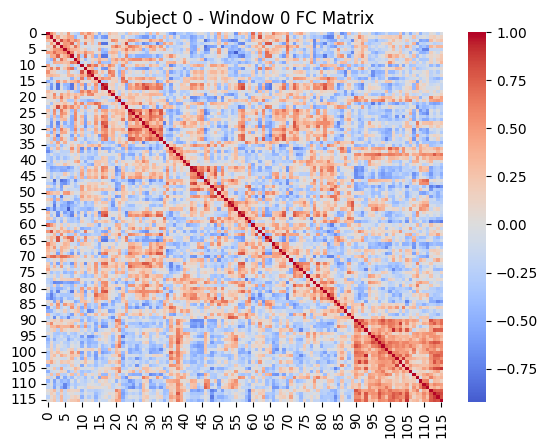

In [ ]:
# compute FC matrix per slice
import matplotlib.pyplot as plt
import seaborn as sns  

subject_fc_matrices = []  # [subject][window] 

for subject in subject_windows:
    subject_fc = []
    for window_df in subject:
        fc_matrix = window_df.corr(method='pearson') # Pearson correlation matrix (FC matrix)
        subject_fc.append(fc_matrix)
    subject_fc_matrices.append(subject_fc)

# Visualize FC matrix of subject 0, window 0
sns.heatmap(subject_fc_matrices[0][0], cmap='coolwarm', center=0)
plt.title("Subject 0 - Window 0 FC Matrix")
plt.show()

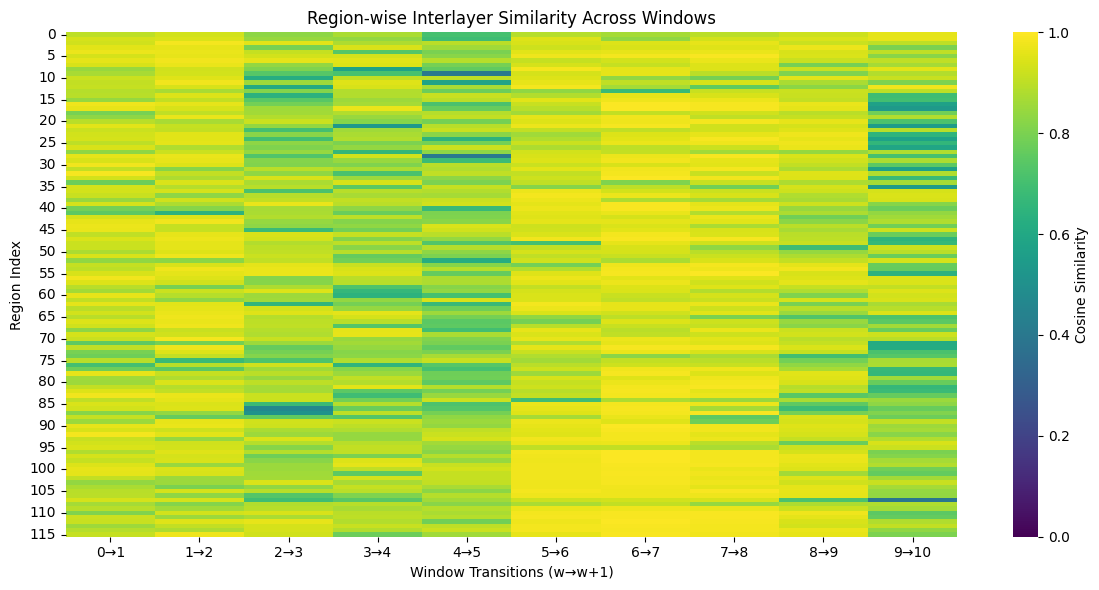

In [ ]:
%matplotlib inline
# adjacency matrix for INTERLAYER connections

# notes abt this -> sa pag gawa nung weights may overlap ung FC matrices kasi nga sliding window so FC 1 is timestep 0-40 
# tapos FC 2 is timestep 10-50 kaya mataas ung correlation almost all of the time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def build_interlayer_adjacency(fc_matrices_subject):
    numWindows = len(fc_matrices_subject)
    numRegions = fc_matrices_subject[0].shape[0]
    
    # init output matrix: rows = window transitions, columns = regions
    adj_matrix = np.zeros((numWindows - 1, numRegions))

    for w in range(numWindows - 1):
        fc1 = fc_matrices_subject[w].fillna(0)  # Replace NaN with 0
        fc2 = fc_matrices_subject[w + 1].fillna(0)

        for r in range(numRegions):
            vec1 = fc1.iloc[r, :].values
            vec2 = fc2.iloc[r, :].values

            # Check for NaN or low variance
            if np.isnan(vec1).any() or np.isnan(vec2).any():
                weight = 0
            elif np.std(vec1) < 1e-10 or np.std(vec2) < 1e-10:
                weight = 0
            else:
                corr = np.corrcoef(vec1, vec2)[0, 1]
                weight = corr if not np.isnan(corr) else 0

            adj_matrix[w, r] = weight

    return adj_matrix

interlayer_adjacency_matrices = []

for s in subject_fc_matrices:
    adj = build_interlayer_adjacency(s)
    interlayer_adjacency_matrices.append(adj)

# visualization
adj = interlayer_adjacency_matrices[0]  # subject 0

def plot_interlayer_similarity_matrix(matrix, use_cosine=True):
    transposed = matrix.T  # transpose kasi baliktas ung output ng build

    plt.figure(figsize=(12, 6))
    sns.heatmap(transposed, cmap='viridis', vmin=0, vmax=1,
                xticklabels=[f'{i}→{i+1}' for i in range(transposed.shape[1])],
                yticklabels=5,
                cbar_kws={'label': 'Cosine Similarity' if use_cosine else 'Correlation'})
    
    plt.title("Region-wise Interlayer Similarity Across Windows")
    plt.xlabel("Window Transitions (w→w+1)")
    plt.ylabel("Region Index")
    plt.tight_layout()
    plt.show()

plot_interlayer_similarity_matrix(adj)